# Table of Contents
* Problem Analysis
* Exploratory Data Analysis
* Data Preprocessing
* Baseline Model Performance
* Hyperparameter Tuning
* Model Results & Interpretation

## Questions & Answers
- **Tell us how you validate your model, which, and why you chose such evaluation technique(s)**
    * Validation is done on a held-out test set (30% of dataset), to prevent data leakage.
    * Given that the evaluation metric chosen for the competition is AUCROC, I used the same evaluation metric for validation on kfold cross validation. For reasons explained below, this is a good metric to use.
- **What is AUC? Why do you think AUC was used as the evaluation metric for such a problem? What are other metrics that you think would also be suitable for this competition?**
    * AUC is the area under the receiver operating characteristic curve, which **measures the ability of a classifier to distinguish between classes across different threshold values**.
    * Poor metrics to use include accuracy, which is unsuitable due to the imbalanced nature of the target variable (baseline model predicting 0s will get 94% accuracy).
    * For this problem, false negatives are more severe than false positives, as it is more detrimental to the bank if a customer defaults, than for it to lose a customer that would not have defaulted. Also, a human can be in the loop to verify positive cases, hence the model can act as an initial filter for possible defaulters. As such, **recall** is more important than precision.
    * However, using only recall will cause the model to be imprecise. To balance precision with recall, we can use the **F-measure**, include the F1 score, which weights precision and recall equally. Since recall is more important than precision, we can use **F-Beta** for Beta > 1, e.g. Beta = 2.
    * Varying the classifier's threshold value allows us to tradeoff precision with recall and vice versa, and **AUCROC** is a metric that captures this notion, ranging from 0.5 (baseline model) to 1 (higher is better). Hence, we can plot the ROC curve and select for a threshold where the model's recall is sufficiently high for our business case, while remaining sufficiently precise.
- **What insight(s) do you have from your model? What is your preliminary analysis of the given dataset?**
    * Detailed analysis shown in notebook below
- **Can you get into the top 100 of the private leaderboard, or even higher?**
    * Validation AUCROC: 86.6%, Test set (30% of dataset) AUCROC: 86.6%, Kaggle AUCROC: 86.083%
    * Kaggle performance: **Public: 141 / 924 (top 15%)**, Private: 519 / 924 (top 56%)

# Problem Analysis

## Problem Statment
Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by **predicting the probability that somebody will experience financial distress in the next two years**.

The goal of this competition is to **build a model that borrowers can use to help make the best financial decisions**. Historical data are provided on 250,000 borrowers.

## Key Observations

1. Goal is for borrowers to understand what they can do to improve their credit score. Hence, **model explainability is important**, where interpretable model outputs give actionable insights for borrowers.
2. Problem is a **binary classification** problem of whether customer will default in the next 2 years.
3. From the bank's perspective: **False negatives are more costly than false positives**, as they lose more money and create negative social impact when customers default on their loans (a la Global Financial Crisis, 2008), hence outweighing the loss of interest earned from customer loans. Hence **Recall > Precision in importance**. To mitigate, this model can have a human-in-the-loop to process credit application rejections to combat unfairness complaints.
4. As model as broader societal implications (rich get richer), **model fairness is of utmost importance**. Hence, using features that can be deemed unfair, e.g. gender, religion, nationality, age, should be minimised.

In [ ]:
!pip install numba==0.48
!pip install aif360==0.2.2
!python -m pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 20.2 MB 1.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
     |████████████████████████████████| 56.4 MB 1.1 MB/s 
     |████████████████████████████████| 2.6 MB 5.5 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=71d431dfff32093b3f49b2a7f083c7abc43c575fc006d8134adcc7eedc100eba
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
Successfully built BlackBoxAuditing
     |████████████████████████████████| 92.6 MB 78 kB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |█████████████████

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, plot_roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from xgboost import XGBClassifier
!pip install shap
import shap

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
root_folder = '/kaggle/input/GiveMeSomeCredit/'
'''

     |████████████████████████████████| 564 kB 5.3 MB/s 


"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        \nroot_folder = '/kaggle/input/GiveMeSomeCredit/'\n"

# Exploratory Data Analysis

## Loading & Visualizing data

10 features, 150k observations: **Moderate sized dataset with few features** (more long than wide)

In [ ]:
# removing unused first (index) column
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/finalProject_rds/cs-training.csv').iloc[:,1:]
df

Mounted at /content/drive


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [ ]:
target_variable = "SeriousDlqin2yrs"

## Data Dictionary
Features can be classified into:
   1. Historical late repayments in the last 2 years(3 window periods of 30-59, 60-89, >=90)
   2. Financial Obligations (NumberOfOpenCreditLinesAndLoans, NumberOfDependents, DebtRatio, RevolvingUtilizationOfUnsecuredLines)
   3. Financial Capabilities (MonthlyIncome)
   4. Demographics (Age)

| Variable Name                        | Description                                                                                                                                              | Type       |
| ------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------- |
| SeriousDlqin2yrs                     | Person experienced 90 days past due delinquency or worse                                                                                                 | Y/N        |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age                                  | Age of borrower in years                                                                                                                                 | integer    |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years.                                                                  | integer    |
| DebtRatio                            | Monthly debt payments, alimony,living costs divided by monthy gross income                                                                               | percentage |
| MonthlyIncome                        | Monthly income                                                                                                                                           | real       |
| NumberOfOpenCreditLinesAndLoans      | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)                                                     | integer    |
| NumberOfTimes90DaysLate              | Number of times borrower has been 90 days or more past due.                                                                                              | integer    |
| NumberRealEstateLoansOrLines         | Number of mortgage and real estate loans including home equity lines of credit                                                                           | integer    |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years.                                                                  | integer    |
| NumberOfDependents                   | Number of dependents in family excluding themselves (spouse, children etc.)                                                                              | integer    |



## Visualizing distributions of features

Initial exploration on the dependent variables, to get an intuition on what models will perform well on this problem, and on how to prepare the dataset for training.

In [ ]:
df.describe(percentiles=[.25,.5,.75,.9,.95,.99,.999])

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
90%,0.000000,0.981278,72.000000,1.000000,1267.000000,1.166600e+04,15.000000,0.000000,2.000000,0.000000,2.000000
95%,1.000000,1.000000,78.000000,2.000000,2449.000000,1.458760e+04,18.000000,1.000000,3.000000,1.000000,3.000000
99%,1.000000,1.092956,87.000000,4.000000,4979.040000,2.500000e+04,24.000000,3.000000,4.000000,2.000000,4.000000


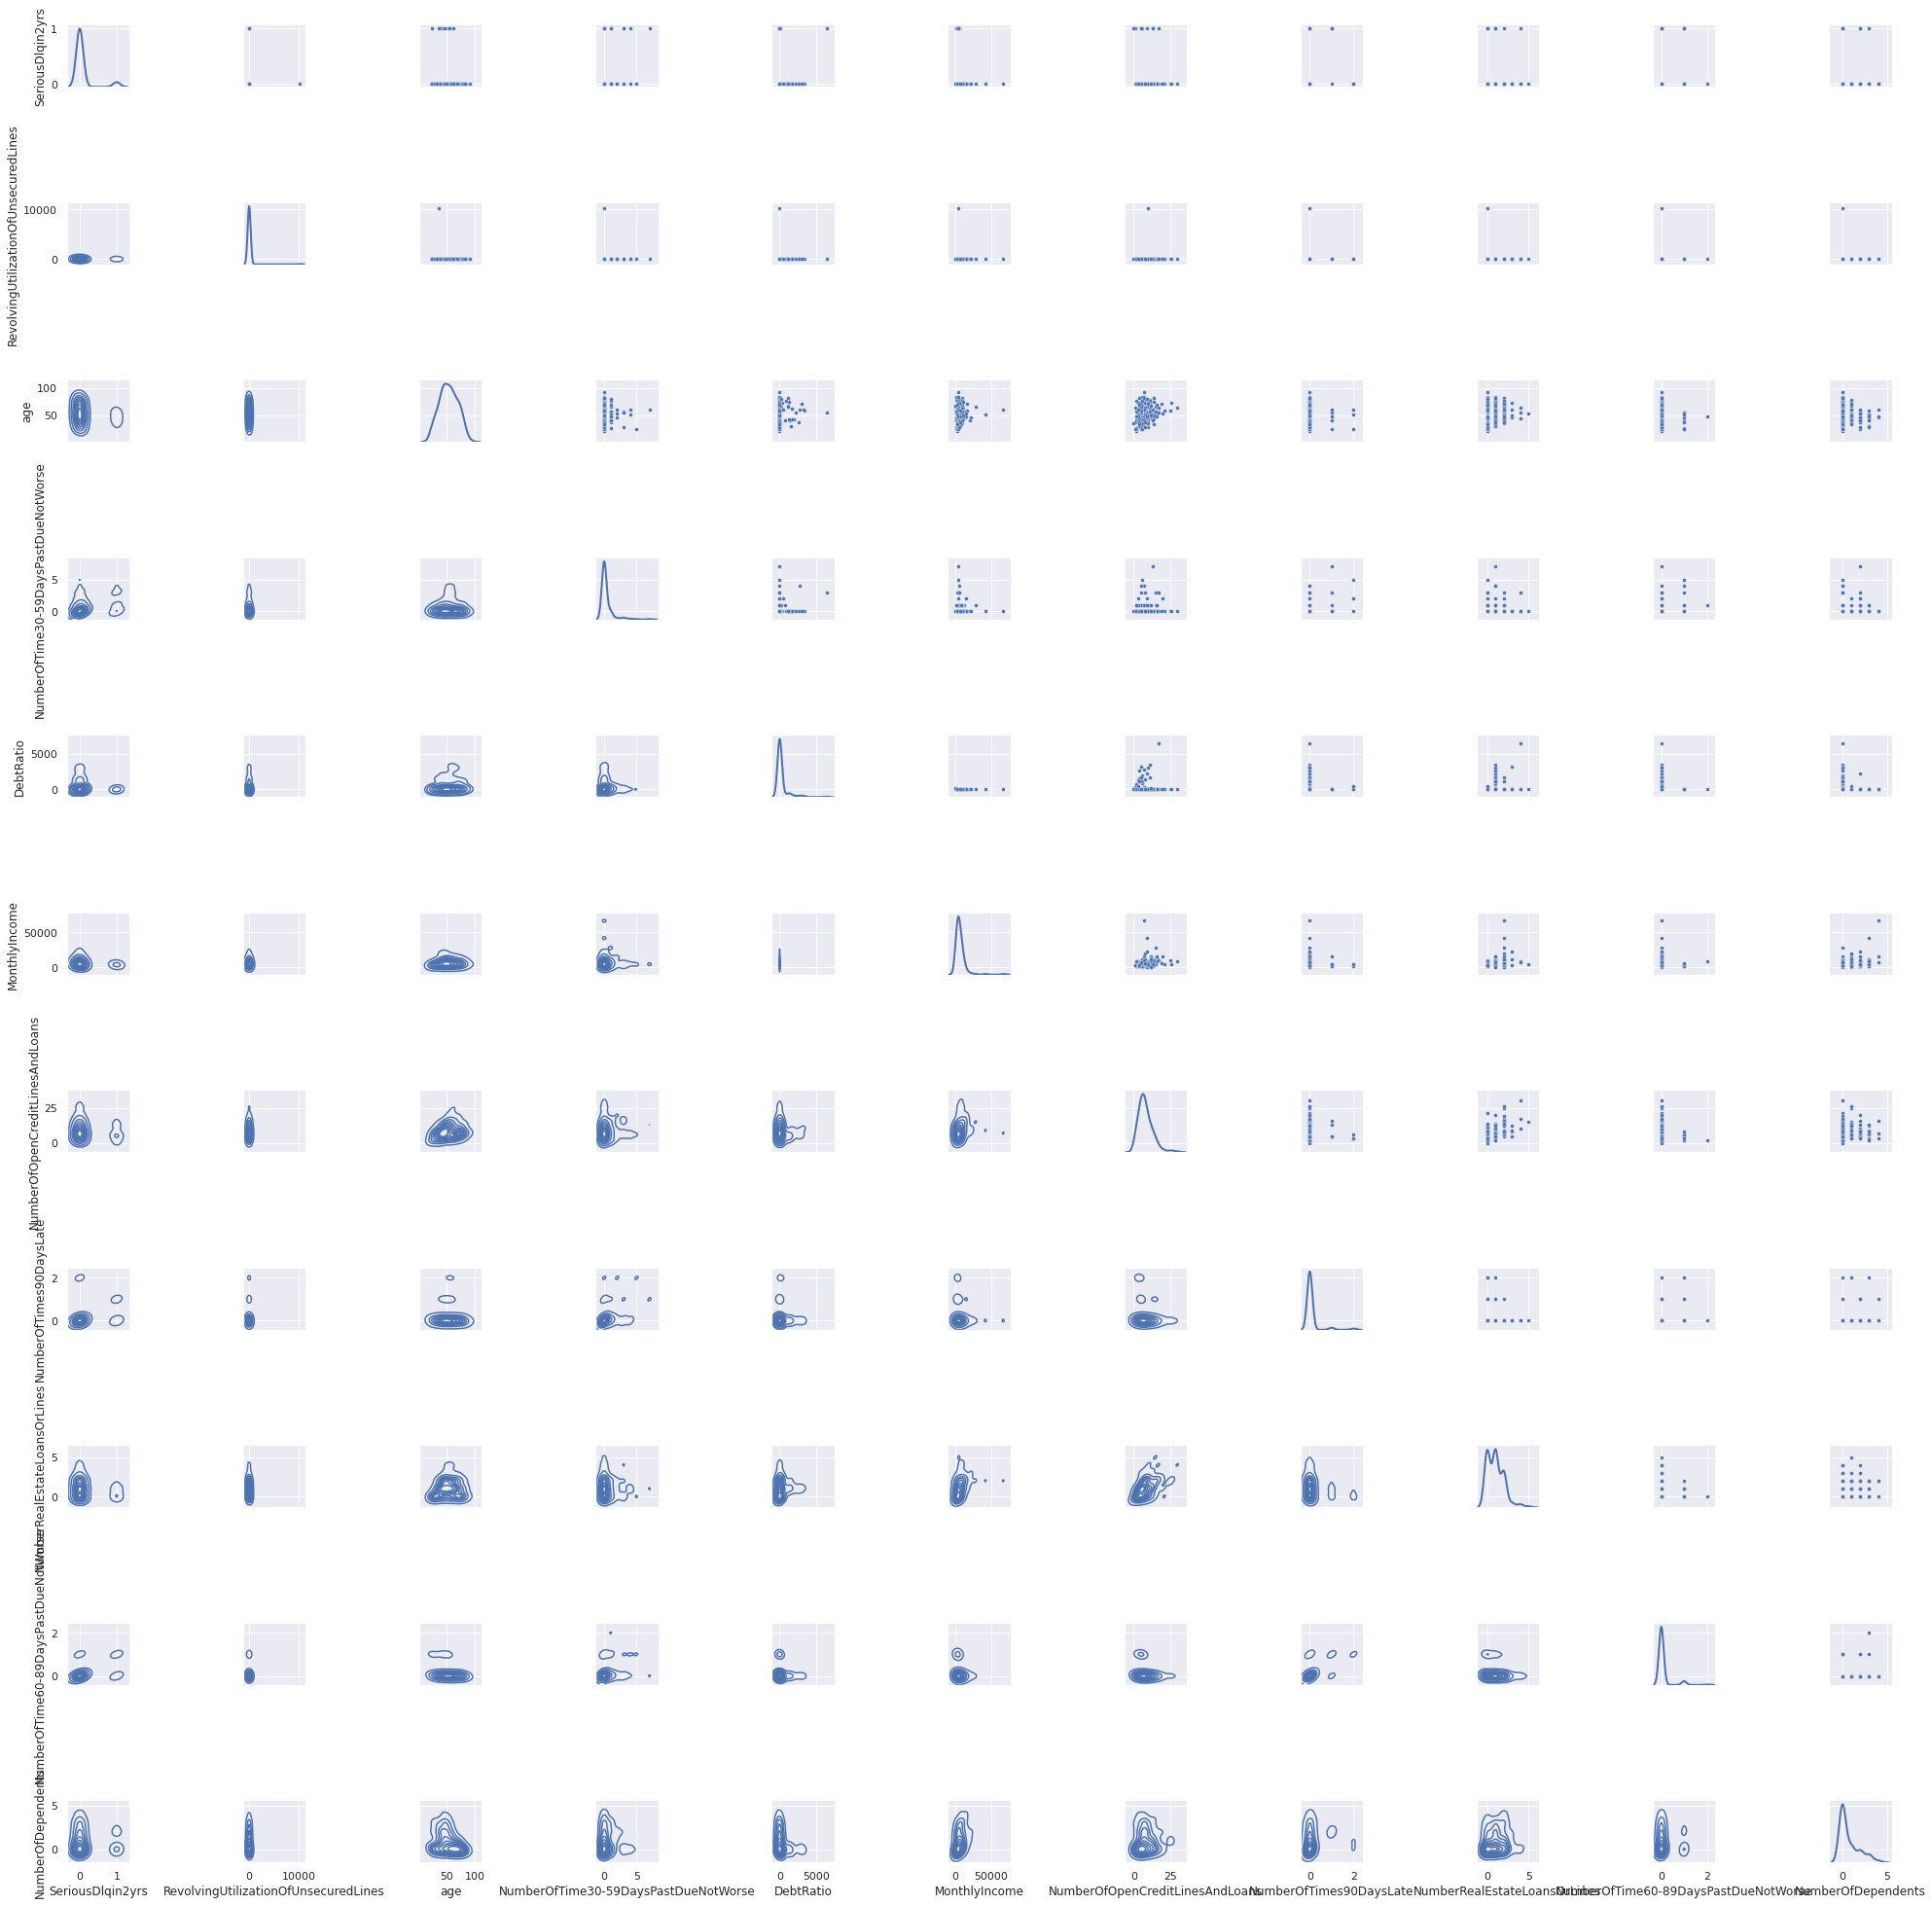

In [ ]:
g = sns.PairGrid(df.sample(150), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2);

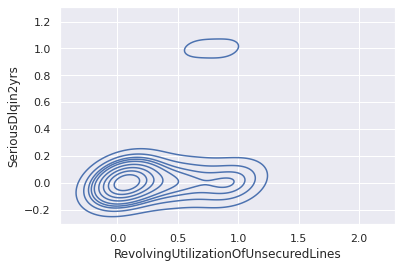

In [ ]:
sns.kdeplot(data=df.sample(150), x="RevolvingUtilizationOfUnsecuredLines", y=target_variable, 
            thresh=.1)

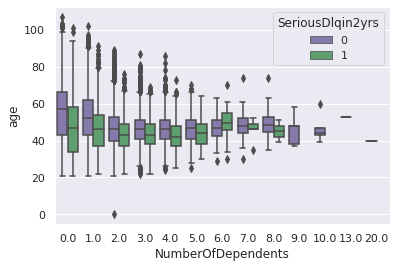

In [ ]:
sns.boxplot(x="NumberOfDependents", y="age",
            hue="SeriousDlqin2yrs", palette=["m", "g"],
            data=df)

### Checking target variable distribution

Looking at the distribution of the target variable, this problem is a binary classification problem of classes 0 or 1 denoting if cusomter will default in 2 years, with class 1 being the minority at 6.684%

Hence, this is an **imbalanced learning problem**

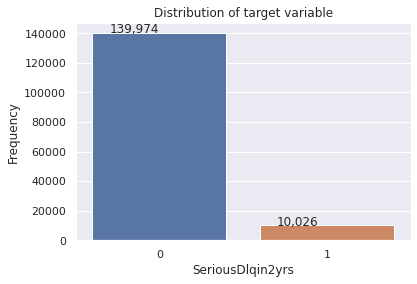

In [ ]:
ax = sns.countplot(x=target_variable, data=df)
plt.title('Distribution of target variable')
plt.xlabel(target_variable)
plt.ylabel('Frequency')

for p in ax.patches:
        ax.annotate('{:,}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### Checking for NAs
Importance: Many learning algorithms cannot handle missing values, hence we need to handle missing values by dropping these observations, or imputing them. Imputing will increase the bias in our model, but dropping too many observations leads to a much smaller dataset for training. We will explore the dataset to drive our imputation strategy.

Only **2 features have nulls** (Monthly income and number of dependents). This could be due to customers not wanting to declare these personal information.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [ ]:
features_with_na = df.isna().sum()[df.isna().sum()>0]
features_with_na.sort_values(ascending=False)

MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64

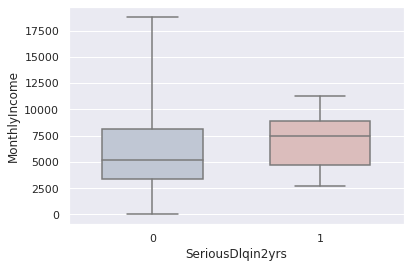

In [ ]:
sns.boxplot(x=target_variable, y="MonthlyIncome", data=df.sample(150),
            whis=[0, 100], width=.6, palette="vlag");

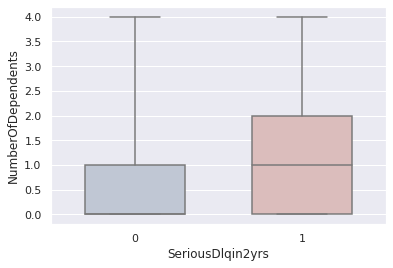

In [ ]:
sns.boxplot(x=target_variable, y="NumberOfDependents", data=df.sample(150),
            whis=[0, 100], width=.6, palette="vlag");

We have 29k observations with >= 1 feature having NA values, corresponding to **20% of the dataset, which is quite significant**. We will **have to impute these NA values** rather than dropping observations with NA. **Monthly Income and NumberOfDependents** have right tail skews, so **median imputation** is preferred to be robust to outliers.

In [ ]:
(df.isna().sum(axis=1)[df.isna().sum(axis=1)>0]
         .reset_index().rename(columns={0:'number_of_na'})
         .groupby('number_of_na')
         .count().rename(columns={'index':'number_of_observations'}))

,number_of_observations
number_of_na,
1,25807
2,3924


### Detecting outliers

Many of the financial features have outliers (extreme outliers = > 3* interquartile range), with a right-tail skew. Hence, we should **either use models that are robust to outliers (e.g. tree-based models), or transform the features accordingly (e.g. Box-Cox transformation)**.

In [ ]:
def get_outlier_counts(df, outlier_threshold=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outlier_counts = ((df < (Q1 - outlier_threshold * IQR)) | (df > (Q3 + outlier_threshold * IQR))).sum()
    return outlier_counts[outlier_counts>0].sort_values(ascending=False)

get_outlier_counts(df, outlier_threshold=3)

DebtRatio                               30457
NumberOfTime30-59DaysPastDueNotWorse    23982
SeriousDlqin2yrs                        10026
NumberOfTimes90DaysLate                  8338
NumberOfTime60-89DaysPastDueNotWorse     7604
MonthlyIncome                            1557
NumberOfDependents                        991
NumberOfOpenCreditLinesAndLoans           442
RevolvingUtilizationOfUnsecuredLines      339
NumberRealEstateLoansOrLines              209
dtype: int64

In [ ]:
df.describe(percentiles=[.25,.5,.75,.9,.95,.99,.999])

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
90%,0.000000,0.981278,72.000000,1.000000,1267.000000,1.166600e+04,15.000000,0.000000,2.000000,0.000000,2.000000
95%,1.000000,1.000000,78.000000,2.000000,2449.000000,1.458760e+04,18.000000,1.000000,3.000000,1.000000,3.000000
99%,1.000000,1.092956,87.000000,4.000000,4979.040000,2.500000e+04,24.000000,3.000000,4.000000,2.000000,4.000000


### Checking for correlations

1. Detecting multicollinearity: **30, 60 and 90 days past due are highly correlated with each other** (close to 1). This may impact performance if the learning algorithm used assumes independence in dependent variables. We can **either use models that are robust to multicollinearity (e.g. tree-based models), or use feature selection / regularization methods to use just one of these features.**

2. **30/60/90 days late payment** features have slight positive correlation with the target variable (0.12), while **age** has slight negative correlation with the target variable (-0.12). These are likely **useful features for predicting the target**.

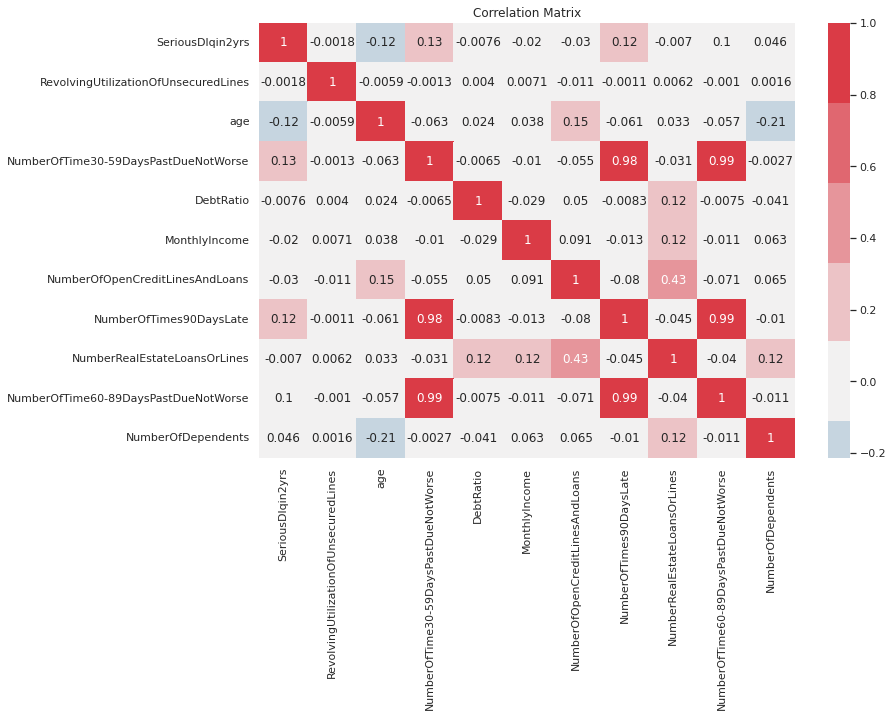

In [ ]:
fig = plt.figure(figsize = [12,8])
sns.heatmap(df.corr(), cmap=sns.diverging_palette(240, 10, n=9),annot=True, center=0)
plt.title("Correlation Matrix", fontsize=12);

### Handling duplicates

Getting counts of number of rows by the number of duplicates: Most severe = 1 observations with 12 instances. Overall, the training set has not too many duplicates, hence will not likely bias the model much. These duplicates are only a problem if they came from non-random error, e.g. duplicate entry into database. In a real scenario, we should dig deeper to identify if these are errors or coincidences. For this problem, we **will not remove these duplicates and assume they are correct**.

In [ ]:
len(df[df.duplicated()])

609

In [ ]:
(df.groupby(df.columns.tolist(),as_index=False)
     .size()['size'].value_counts())

1     120121
2         31
3          7
5          4
4          3
8          1
6          1
12         1
7          1
Name: size, dtype: int64

# Feature Engineering

## Train test split

**Train test split** is important to leave out a hold-out set (**30%** of dataset size) for evaluation, to **prevent data leakage**.

In [ ]:
!pip install fairlearn
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate


X, y = df.iloc[:,1:], df.loc[:,target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

     |████████████████████████████████| 177 kB 5.3 MB/s 


In [ ]:
y_train

27822     0
85202     0
42217     0
119958    0
37678     0
         ..
119879    0
103694    0
131932    0
146867    0
121958    0
Name: SeriousDlqin2yrs, Length: 105000, dtype: int64

## Data Preprocessing

Based on EDA, we have found the need for imputation and scaling. Hence, we assemble a **pipeline of imputation (median) and scaling (Box-Cox via PowerTransformer)**, testing out different classifiers to compare model performance. Based on experimentation, model performance when training with SMOTE for synthetic oversampling of the minority class did not significantly improve performance.


In [ ]:
def get_pipeline(classifier, random_seed=42):
    """Takes in a classifier, returns the entire data preprocessing pipeline (imblearn pipeline)"""
    return Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    # SMOTE(sampling_strategy='minority', random_state=random_seed), -> removed due to poor performance
                    ('scaler', PowerTransformer()),
                    ('clf', classifier)
                    ])

## Baseline models

We train several baseline models using different learning algorithms to get a sense of what learning algorithm best performs during **k-fold cross validation**. In the interest of time, we perform model selection with minimal hyperparameter tuning, and **select the model with best performance on cross-validation score**. Ideally,this selection process happens after hyperparameter tuning for all of the models.

In [ ]:
def train_models(classifiers, num_folds=3, random_seed=42):
    # models = dict()
    results = dict()
    for classifier in classifiers:
        curr_time = time.time()
        model = get_pipeline(classifier, random_seed=random_seed)
        kfold = KFold(n_splits=num_folds)
        print(f'Training {classifier.__class__.__name__}')
        score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
        print("%0.2f AUC with a standard deviation of %0.2f" % (score.mean(), score.std()))
        # models[classifier.__class__.__name__] = model
        results[classifier.__class__.__name__] = score
        print(f'Training took {round(time.time()-curr_time)} seconds')
    print('Training complete')
    return results


classifiers = [
    GaussianNB(),
    KNeighborsClassifier(5),
    LogisticRegression(),
    RandomForestClassifier(),
    XGBClassifier(),
]
results = train_models(classifiers)
results

Training GaussianNB
0.85 AUC with a standard deviation of 0.01
Training took 6 seconds
Training KNeighborsClassifier
0.74 AUC with a standard deviation of 0.00
Training took 31 seconds
Training LogisticRegression
0.85 AUC with a standard deviation of 0.01
Training took 4 seconds
Training RandomForestClassifier
0.84 AUC with a standard deviation of 0.01
Training took 39 seconds
Training XGBClassifier
0.86 AUC with a standard deviation of 0.01
Training took 14 seconds
Training complete


{'GaussianNB': array([0.84299178, 0.85233631, 0.85643623]),
 'KNeighborsClassifier': array([0.73639889, 0.73876992, 0.73299556]),
 'LogisticRegression': array([0.84389725, 0.85407455, 0.8578389 ]),
 'RandomForestClassifier': array([0.82977369, 0.8430844 , 0.84387716]),
 'XGBClassifier': array([0.85479149, 0.86650417, 0.86929129])}

## Hyperparameter tuning

Based on the baseline model performances, **XGBoost algorithm** performed the best (**highest AUC with lowest standard deviation across 3 folds**). To improve performance, we tune the model hyperparameters using **randomized search**, which does random search over the range of hyperparameters. This is faster than grid search, which exhaustively searches over all possible hyperparameters in the range provided.

In [ ]:
model = get_pipeline(XGBClassifier(n_jobs=-1))

xgb_hyperparams = {
    'clf__max_depth' : np.arange(4,10,1),
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__n_estimators' : np.arange(400,1000,100),
    'clf__subsample': np.arange(0.5,1,0.1),
    'clf__scale_pos_weight': [10,15,20] # Imbalanced ratio of 94:6, hence add weight to negative class
    
}

clf = RandomizedSearchCV(estimator=model,
                         param_distributions=xgb_hyperparams,
                         scoring='roc_auc',
                         n_iter=20,
                         verbose=2)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END clf__learning_rate=0.1, clf__max_depth=8, clf__n_estimators=600, clf__scale_pos_weight=10, clf__subsample=0.8999999999999999; total time= 1.3min
[CV] END clf__learning_rate=0.1, clf__max_depth=8, clf__n_estimators=600, clf__scale_pos_weight=10, clf__subsample=0.8999999999999999; total time= 1.1min
[CV] END clf__learning_rate=0.1, clf__max_depth=8, clf__n_estimators=600, clf__scale_pos_weight=10, clf__subsample=0.8999999999999999; total time= 1.1min
[CV] END clf__learning_rate=0.1, clf__max_depth=8, clf__n_estimators=600, clf__scale_pos_weight=10, clf__subsample=0.8999999999999999; total time= 1.1min
[CV] END clf__learning_rate=0.1, clf__max_depth=8, clf__n_estimators=600, clf__scale_pos_weight=10, clf__subsample=0.8999999999999999; total time= 1.1min
[CV] END clf__learning_rate=0.01, clf__max_depth=8, clf__n_estimators=400, clf__scale_pos_weight=10, clf__subsample=0.7; total time=  52.0s
[CV] END clf__learning_rate=

## Final model

We evaluate model performance using ROC AUC, which is the **area under the receiver operating characteristic curve**. 

In [ ]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    predicted_proba = model.predict_proba(X_test)
    # Default score: Mean accuracy, which is not a good evaluation metric for a imbalanced dataset problem
    print('accuracy', model.score(X_test, y_test))
    print('confusion_matrix')
    print(confusion_matrix(y_test, predictions))
    print('roc_auc',roc_auc_score(y_test, predicted_proba[:,1]))
    print('classification_report')
    print(classification_report(y_test, predictions))
    matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
    sns.heatmap(matrix,annot=True)
    plot_roc_curve(model, X_test, y_test)
    

From the model classification report, we see that its **recall for the positive class is high at 84%**. This is preferred, as per business use case where **type II errors are more costly than type I errors**. Overall, its **ROC is 86.6% on the held out test set**, which is similar to the average **86.4% on cross-validation set**, showing that the **model can perform well with out-of-sample data (i.e. is not overfitted)**.

accuracy 0.7318888888888889
confusion_matrix
[[30423 11597]
 [  468  2512]]
roc_auc 0.8666600795722075
classification_report
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     42020
           1       0.18      0.84      0.29      2980

    accuracy                           0.73     45000
   macro avg       0.58      0.78      0.56     45000
weighted avg       0.93      0.73      0.80     45000



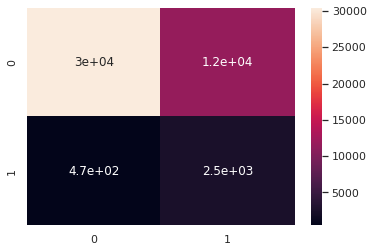

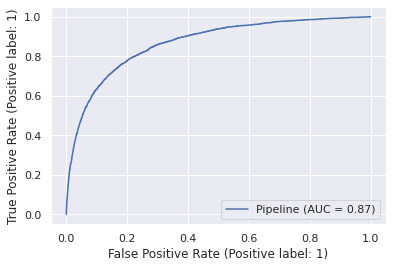

In [ ]:
model = get_pipeline(XGBClassifier(max_depth=4,
                                   learning_rate=0.01,
                                   n_estimators=800,
                                   subsample=0.5,
                                   scale_pos_weight=20,
                                   n_jobs = -1))

model.fit(X_train, y_train)
evaluate_model(model, X_test, y_test)

### Model explainability

From the feature importances, we see that **current utilization of credit (RevolvingUtilizationOfUnsecuredLines), 30-59 and >90 days late are the most useful features**. This **corresponds well with our intuition** that customers with history of frequent late payments and with are more likely to be delinquent on loan repayment in the future.

**For customers**, the actionable insights are that **the feature importances can be interpreted as a priority list of issues to fix for improving their credit score**. For example, ensuring one has low utilization of unsecured lines is more impactful in improving credit scoring than increasing their debt ratio or monthly income.

In [ ]:
(pd.DataFrame(model['clf'].feature_importances_, X_train.columns)
     .reset_index()
     .rename({'index':'features', 0:'feature_importance'}, axis=1)
     .sort_values(by=['feature_importance'], ascending=False))

,features,feature_importance
0,RevolvingUtilizationOfUnsecuredLines,0.260650
2,NumberOfTime30-59DaysPastDueNotWorse,0.209603
6,NumberOfTimes90DaysLate,0.193689
8,NumberOfTime60-89DaysPastDueNotWorse,0.122843
7,NumberRealEstateLoansOrLines,0.064201
1,age,0.040588
5,NumberOfOpenCreditLinesAndLoans,0.038232
3,DebtRatio,0.025413
4,MonthlyIncome,0.023480
9,NumberOfDependents,0.021301


The **SHAP model quantifies the contributions that each feature brings to generate the model outputs**. Plotting the average contributions across all predictions, we can visualize how much each value affect's one's probability of the model predicting one's delinquency in the next 2 years (and hence credit score). For example, we see that **higher RevolvingUtilizationOfUnsecuredLines leads to higher probability of delinquency**, as visualized by red scatter points having positive SHAP values.

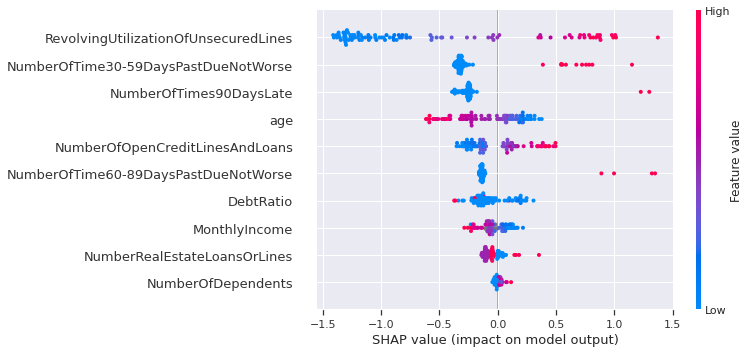

In [ ]:
def plot_shap(model, df):
    #Plots shapely values for model explainability
    X_sampled = df.sample(100)

    explainer = shap.TreeExplainer(model['clf'])
    observations = model['scaler'].transform(model['imputer'].transform(X_sampled))
    
    shap_values = explainer.shap_values(observations)
    shap.summary_plot(shap_values, X_sampled)
    
plot_shap(model, X_test)

# Saving outputs

 **XGBoost AUCROC for the test results were 0.86083%**. On the public leaderboard, this would be **position 141 / 924 (top 15%)**.

In [ ]:
def get_output(model, test_df):
    output_predictions = model.predict_proba(test_df.iloc[:,2:])
    output_df = pd.DataFrame(output_predictions[:,1]).rename(columns={0:'probability'})
    output_df['id'] = range(1,len(output_df)+1)
    output_df = output_df.loc[:,['id','probability']]
    return output_df

test_df = pd.read_csv('/content/drive/MyDrive/finalProject_rds/cs-test.csv')
test_df


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
101498,101499,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,101500,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,101501,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101501,101502,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0


In [ ]:
output_df = get_output(model, test_df)

output_df.to_csv('output_predictions.csv', index=False)
output_df

,id,probability
0,1,0.625693
1,2,0.535452
2,3,0.177992
3,4,0.641793
4,5,0.687188
...,...,...
101498,101499,0.371469
101499,101500,0.900008
101500,101501,0.069600
101501,101502,0.609312


In [ ]:
import sklearn.metrics as skm

y_pred = clf.predict(X_test)

# get the overall performance metrics of the classifer
print('precision:', skm.precision_score(y_test, y_pred))
print('recall:', skm.recall_score(y_test, y_pred))
print('average_precision:', skm.average_precision_score(y_test, y_pred))

precision: 0.20229040252969832
recall: 0.7942953020134228
average_precision: 0.17430053859396583


In [ ]:
output_predictions = model.predict_proba(test_df.iloc[:,2:])
output_predictions = output_predictions[:,1]
output_predictions
median = np.median(output_predictions)
mean = np.mean(output_predictions)
print("Median: " + str(median))
print("Mean: " + str(mean))

Median: 0.2883455
Mean: 0.3768879


In [ ]:
age=test_df["age"]
median_age = np.median(age)
median_age
mean_age = np.mean(age)
mean_age

count = 0
for i in age:
  if i <=25:
    count +=1

count

2036

In [ ]:
d = {'age':age,'probability':output_df['probability'] }
df = pd.DataFrame(data=d)
df.loc[df["age"] <= 25, "age"] = 0
df.loc[df["age"] > 25, "age"] = 1
df.loc[df["probability"] <= median, "probability"] = 0
df.loc[df["probability"] > median, "probability"] = 1
young = df[df["age"]==0]
num_young = young.shape[0]
old = df[df["age"]==1]
num_old = old.shape[0]

In [ ]:
unprivileged_outcomes = young[young['probability'] == 1].shape[0]
unprivileged_ratio = unprivileged_outcomes/num_young
unprivileged_ratio

0.7274066797642437

In [ ]:
privileged_outcomes = old[old['probability'] == 1].shape[0]
privileged_ratio = privileged_outcomes/num_old
privileged_ratio

0.4953401630691586

In [ ]:
disparate_impact = unprivileged_ratio/privileged_ratio
disparate_impact

1.4684992940148167